In [9]:
### Libraries imports

import matplotlib.pyplot as plt
import numpy as np
import Geodesics as gd
import Model as md
import cmath as cmt
import glob
import os
import time
from scipy.optimize import curve_fit as cf
from Functions import *
import hypertiling as ht
from collections import Counter

### Pyplot parameters for plotting
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',  # Use a serif font
    'font.size': 10,         # Adjust the font size to match your LaTeX document
})

# For a two-column document, set the figure width to be within the column width
column_width_pt = 246  # Adjust this based on your document's column width
inches_per_pt = 1/72.27
golden_ratio = (5**0.5 - 1) / 2  # Golden ratio to make the figure aesthetically pleasing

fig_width = column_width_pt * inches_per_pt
fig_height = fig_width * golden_ratio



plt.style.use('default')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "lines.linewidth" : 1.2,
          'xtick.minor.width' : 0.75,
          'xtick.major.width' : 0.75,
          'ytick.minor.width' : 0.75,
          'ytick.major.width' : 0.75,
          'axes.spines.top' : True,
          'axes.spines.right' : True,
          'axes.linewidth' : 1.5}
plt.rcParams.update(params)
plt.rc('figure', figsize=(fig_width, fig_height))
plt.rc('legend', frameon=False)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')

In [2]:
lattice54Sizes = np.array([0,0,10,40,150,560,2090,7800])
lattice64Sizes = np.array([0,0,12,72,420,2448,14268])
lattice74Sizes = np.array([0,0,14,112,882,6944])

## Monte Carlo Simulation at zero temperature

In [ ]:
def monteCarloZeroT(p,layers,totalSteps,logSteps,decorrSteps,verbose = False, q = 4):
    '''
    Performs monte Carlo simulation at zero temperature
    Inputs:
        p: int, polygon sides
        layers: list of number of layers to simulate
        totalSteps: Amount of monte carlo steps per geodesic
        logSteps: steps between each log
        decorrSteps: steps to decorrelate the system
        verbose: bool, if true prints to screen more details of the progress.
        q: int, coordination number. Only q=4 implemented so far
    Outputs:
        Saves the correlation at zero temperature obtained through monte carlo in the corresponding folder.
    '''
    for nlayers in layers:
        #Set up model
        start = time.time()
        if verbose:
            print("Defining model with " + str(nlayers) + " layers", end = '\r')
        model = md.FractonModel(p,q,nlayers)
        end = time.time()
        elapsed = end-start
        nSpins = len(model.lattice)
        nGeods = len(model.geodesicList)
        if verbose:
            print("Finished defining model with " + str(nlayers) + " layers. It took: " + str(round(elapsed,2)) + ' s'+' There are '+str(nSpins)+ ' sites and '+str(nGeods) + ' geodesics' +' '*100)
        #Lattice parameters
        nMeasurements = nGeods*totalSteps #Number of measurements
        
        # Define the directory where you want to save the files
        save_dir = f'P{p}Q{q}/{nlayers}Layers'
        timeSeries_dir = os.path.join(save_dir, 'CorrelationsMCZero')
        os.makedirs(save_dir, exist_ok=True)
        os.makedirs(timeSeries_dir, exist_ok=True)

        #Number of spins in the border
        nBorder = len(model.border)
        distances = np.linspace(1,int(nBorder/2), int(nBorder/2))

        #Initialize correlation and states arrays
        corr = np.zeros(int(len(model.border)/2))
        corrTimeSeries = np.zeros((logSteps,int(len(model.border)/2)))
        
        
        #Initialize save counter
        saveCounter = 0
        elapsed = 0
        #Simulation main loop
        for iteration in range(nMeasurements):
            start = time.time()
            model.decorrelate(decorrSteps)
            temp = np.array(model.getBorderCorrelations()/nBorder)
            corrTimeSeries[saveCounter,:] = temp
            corr += temp/nMeasurements
            saveCounter += 1
            end = time.time()
            elapsed += end - start
            if(saveCounter == logSteps):
                print('Computing correlation. \tPercentage: ' + str(round(iteration/nMeasurements*100)) + '% \t' + str(round(iteration/elapsed)) + ' it/s' + '\t Time remaining: ' + str(round((elapsed*(nMeasurements-iteration)/iteration)/60,2)) +' min     ', end = '\r')
                np.save(os.path.join(save_dir, "Correlation" + ".npy"),np.array(corr))
                np.save(os.path.join(timeSeries_dir, "CorrelationTimeSeries"+str(int(iteration/logSteps)) + ".npy"),np.array(corrTimeSeries))
                saveCounter = 0
        if verbose:
            print('Correlation took: ' + str(round(elapsed,2))+' s'+' '*1000, end = '\n')

## Monte Carlo at finite beta

In [12]:
## Swendsen-Wang

def generateBonds(spins, interaction, beta):
    '''
    Function that generates a list of bonds between spins on a lattice following the Swendsen-Wang algorithm
    Input:
        spin: (n,) numpy array
        interaction: (n_l,m_l) numpy array with n_l links and m_l spins indices. The interaction is the product of all the m_l spins. Interaction strength set to 1
        beta: (float) inverse temperature
    Output:
        bondsList: List of bonds. If the bond of index n is on, bondsList[index] = 1, else equals 0
    '''
    bondsList = np.zeros(len(interaction))
    for idx,link in enumerate(interaction):
        prod =1
        for s in link:
            prod *= spins[s]
        prob = 1-np.exp(-beta*prod-beta)
        rand = np.random.uniform()
        if rand<prob:
            bondsList[idx] = 1
    return bondsList

def generateClusters(spins, bondsList, linksList, interaction):
    '''
    Function that generates a list of clusters generated by a list of active bonds.
    Input:
        spins: (n,) numpy array
        interaction: (n_l,m_l) numpy array with n_l links and m_l spins indices. The interaction is the product of all the m_l spins. Interaction strength set to 1
        bondsList: list of bonds, 1 active 0 off
        linksList: list of lists. Item on index n has the list of links that have spin number n
    Output:
        cluster: list of clusters
    '''
    nSpins = len(spins)
    availableSpins = [i for i in range(nSpins)]
    clusters = []
    while nSpins!=0:
        seed = availableSpins[0]
        currentClusterTemp = [seed]
        currentCluster = [seed]
        availableSpins.remove(seed)
        while currentClusterTemp != []:
            site = currentClusterTemp[0]
            for l in linksList[site]:
                if bondsList[l] ==1:
                    for s in interaction[l]:
                        if s not in currentCluster:
                            currentCluster.append(s)
                            currentClusterTemp.append(s)
                            if s in availableSpins:
                                availableSpins.remove(s)
            currentClusterTemp.remove(site)
        nSpins -= len(currentCluster)
        clusters.append(currentCluster)
    return clusters


## Generating Fractons
def distinctVerticesGeods(model):
    '''
    Function that generates a list of distinct vertices on a hyperbolic lattice.
    Inputs:
        model: md.FractonModel object
    Outputs:
        vertex_list: List of vertices positions in the poincare disk
    '''
    vertex_list = []
    for pol in model.bulk:
        vertices = model.lattice.get_vertices(pol)
        for v in vertices:
            add = True
            for v0 in vertex_list:
                if cmt.isclose(v,v0):
                    add = False
            if add:
                vertex_list.append(v)
    return vertex_list

def geodesicsPairs(vertices, model):
    '''
    Function that gives the index of each pair of geodesics that cross each vertex in a hyperbolic lattice on the poincare disk
    Inputs:
        vertices: list of vertices as positions in the poincare disk
        model: md.FractonModel object
    Outputs:
        geodesics: List of pairs of geodesics indices
    '''
    geodesics = []
    for v in vertices:
        gList = []
        for gIdx,g in enumerate(model.geodesicList):
            #print(np.power(np.abs(v+g.center),2)-g.radius)
            if round(np.power(np.abs(v+g.center),2)-g.radius,10) == 0:
                gList.append(gIdx)
        geodesics.append(gList)
    return geodesics

def defineCuadrants(geodesicsPairs,geodesicList, vertices,centers):
    '''
    Function that creates the cuadrants that a vertex in a p,4 lattice creates.
    Inputs:
        geodesicPairs: list with pairs of geodesic indices that cross each vertex.
        geodesicList: list with all geodesics of the lattice
        vertices: list of all vertices of the lattice
        centers: list of all polygon centers of the lattice
    Outputs:
        allCuadrants: list with all four cuadrants for each vertex
    '''
    allCuadrants = []
    for vIdx, v in enumerate(vertices):
        firstGeod = geodesicList[geodesicsPairs[vIdx][0]].vect_inside()(centers)
        secondGeod = geodesicList[geodesicsPairs[vIdx][1]].vect_inside()(centers)
        insideFirstGeod = [idx for idx in range(len(centers)) if firstGeod[idx] == -1]
        insideSecondGeod = [idx for idx in range(len(centers)) if secondGeod[idx] == -1]
        firstCuadrant = [idx for idx in range(len(centers)) if idx in insideFirstGeod and idx in insideSecondGeod ]
        secondCuadrant = [idx for idx in range(len(centers)) if idx in insideFirstGeod and idx not in insideSecondGeod ]
        thirdCuadrant = [idx for idx in range(len(centers)) if idx not in insideFirstGeod and idx in insideSecondGeod ]
        fourthCuadrant = [idx for idx in range(len(centers)) if idx not in insideFirstGeod and idx not in insideSecondGeod ]
        cuadrants = [firstCuadrant,secondCuadrant,thirdCuadrant,fourthCuadrant]
        allCuadrants.append(cuadrants)
    return allCuadrants



In [207]:
### Monte Carlo loop by creating fractons
p = 5; q = 4
nLayers = 5
beta_list = 1/np.arange(0.0,2,0.1)[1:]
model = md.FractonModel(p,q,nLayers)
print('Done with model')
vertices = distinctVerticesGeods(model)
print('Done with vertices')
Nv = len(vertices)
geodesics = geodesicsPairs(vertices,model)
print('Done with geodesic pairs')
cuadrants = defineCuadrants(geodesics,model.geodesicList,vertices,model.centers)
dualSpins = [1 for _ in range(len(vertices))]
energy = -sum(dualSpins)
print(len(model.spins))


Done with model
Done with vertices
Done with geodesic pairs
761


In [208]:
numSteps = 50000
energies = np.zeros((len(beta_list),numSteps))
decorr = 24
correlations = np.zeros((len(beta_list),int(len(model.border)/2)))

for bIdx,b in enumerate(beta_list):
    prob = np.exp(-2*b)
    corrList = np.zeros((int(len(model.border)/2),numSteps))

    for n in range(numSteps):
        start = time.time()
        for n3 in range(len(dualSpins)):
            v = np.random.randint(0,len(vertices))
            c = np.random.randint(0,4)
            deltaE = 2*dualSpins[v]
            if deltaE <0:
                dualSpins[v] = -dualSpins[v]
                model.spins[cuadrants[v][c]] = -model.spins[cuadrants[v][c]]
                energy += deltaE
            else:
                r = np.random.random()
                if r<prob:
                    dualSpins[v] = -dualSpins[v]
                    model.spins[cuadrants[v][c]] = -model.spins[cuadrants[v][c]]
                    energy += deltaE
        model.decorrelate(decorr)
        corrList[:,n] = model.getBorderCorrelations()
        energies[bIdx,n] = energy
        end = time.time()
        elapsed = end-start
        print(f'Estimated remaining time for this temp {round(elapsed,4)/60*(numSteps-n):.2f}m' + ' '*100, end = '\r')
        #model.quick_plot(colors = 'spins')
    correlations[bIdx,:] = np.mean(corrList[:,500:], axis = 1)

np.save("./energies.npy",energies)
np.save("./corrs.npy",correlations)

In [108]:
import scipy.fft
def autoCorrelation2(x, connected = True):
  '''
  Computes the self-correlation of the time series x(t) of a scalar variable. Averaging over initial values t_0. X is an N by M array which contains the N points
  of M realizations of the time series. The N points are all spaced by a time Delta t so that t_i = i*Delta t
  Connected: Is used to indicate if you want to compute the connected correlation or not. Set to True by default
  method: Method that scipy uses to compute the correlation. Set to fast fourier transform by default.
  '''
  x = np.asarray(x)
  if len(np.shape(x))<2:
    x_new = np.copy(x.reshape(np.shape(x)[0],1))
  (N,M) = np.shape(x_new)
  fourierTransform2 = np.zeros((2*N,M),dtype=np.complex128)
  if connected:
    c = np.mean(x_new,axis=0)
    for el in range(M):
      x_new[:,el] = x_new[:,el] - c[el]
  fourierTransform = scipy.fft.fft(x_new,2*N,axis=0)
  corr = scipy.fft.ifft(np.power(np.abs(fourierTransform[:N,:]),2),2*N,axis=0)
  factor = np.array([1/(N-i+1) for i in range(1,N+1)])
  corr = corr[:N,:]
  for n in range(M):
    corr[:,n] = corr[:,n]*factor
  return np.mean(np.real(corr),axis=1)

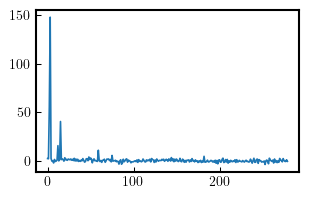

In [173]:
plt.plot(correlations[0,:])
plt.show()

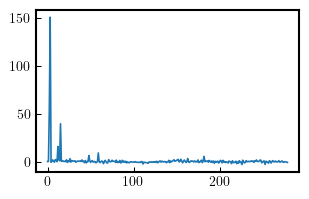

In [177]:
plt.plot(correlations[0,:])
plt.show()

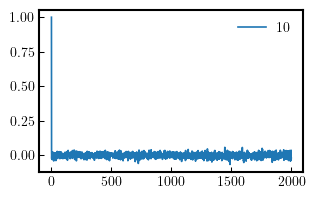

In [174]:
corr2 = autoCorrelation2(magnetizations)
corr3 = autoCorrelation2(energies[0,2500:])

plt.plot(corr2[:2000]/corr2[0],label = '10')
plt.legend()

In [ ]:
model  = md.FractonModel(5,4,6)
beta_list = 1/np.linspace(0.0,2.0,10)
print(1/beta_list[1:])

In [ ]:
print(len(model.border))

In [ ]:
numSteps = 50000
energies = np.zeros(len(beta_list[1:]))
cv = np.zeros(len(beta_list[1:]))
correlations = np.zeros((int(len(model.border)/2),len(beta_list[1:])))
for idx,beta in enumerate(beta_list[1:]):
    enList = np.zeros(numSteps)
    corrList = np.zeros((int(len(model.border)/2),numSteps))
    print(beta)
    for step in range(numSteps):
        start = time.time()
        model.decorrelate(5)
        for waitStep in range(2):
            bonds = generateBonds(model.spins,model.interactions,beta)
            clusters = generateClusters(model.spins,bonds,model.linksList, model.interactions)
            for cl in clusters:
                model.spins[cl] = model.spins[cl]*(np.random.randint(0,2)*2-1)
        enList[step] = model.hamiltonian()/len(model.lattice)
        corrList[:,step] = model.getBorderCorrelations()
        end = time.time()
        print('step = '+str(step)+' time per step = ' + str(end-start)+' '*100,end = '\r') 
    energies[idx] = np.mean(enList)
    cv[idx] = np.var(enList)*beta*beta
    correlations[:,idx] = np.mean(corrList[:,500:], axis = 1)

np.save("./cv6.npy",cv)
np.save("./energy6.npy",energies)
np.save("./correlations6.npy",correlations)
np.save("./betas6.npy",np.array(beta_list[1:]))

In [ ]:
beta_list6 = np.load("./betas6.npy")
energies6 = np.load("./energy6.npy")
correlations6 = np.load("./correlations6.npy")
cv6 = np.load("./cv6.npy")

beta_list = np.load("./betas.npy")
energies = np.load("./energy.npy")
correlations = np.load("./correlations.npy")
print(1/beta_list)
print(1/beta_list6)

In [ ]:
sixLabel = "2090 border pols"
fiveLabel = '560 border pols'

distances6 = np.linspace(1,1045, 1045)/1045
distances = np.linspace(1,280,280)/280

##Energy

plt.plot(1/beta_list6,energies6,label = sixLabel)
plt.plot(1/beta_list,energies,label = fiveLabel)
plt.xlabel("T")
plt.ylabel("e")
plt.legend()
plt.show()
plt.savefig("./Energy.png")

##Correlations
plt.plot(distances6,correlations6[:,4]/2090,label = sixLabel)
plt.plot(distances,correlations[:,13]/560,label = fiveLabel)
plt.xlabel("d")
plt.ylabel(r"$<e(n)e(n+d)>=c(d)$")
plt.legend()
plt.savefig("./Corrs.png")
plt.show()

##CorrelationsHeights
heights6 = [correlations6[3,n]/2090 for n in range(9)]
heights = [correlations[3,n]/560 for n in range(25)]
plt.plot(1/beta_list6,heights6,label = sixLabel)
plt.plot(1/beta_list,heights,label = fiveLabel)
plt.xlabel("T")
plt.ylabel(r"$\text{max}(c(d))$")
plt.legend()
plt.savefig("./CorrHeights.png")
plt.show()


In [ ]:
plt.plot(1/beta_list[1:],energies, 'x-')
plt.show()
heights = [correlations[3,n]/len(model.border) for n in range(9)]
plt.plot(1/beta_list[1:],np.array(heights),'x-')
plt.xlabel('$T$')
plt.ylabel(r'$\text{Max}(C(d))$')
plt.savefig("./CorrelationHeight.png")
plt.show()

distances = np.linspace(1,len(model.border)/2, int(len(model.border)/2))/int(len(model.border))

plt.plot(distances, correlations[:,0]/len(model.border), label = 'T = '+str(1/beta_list[1]))
plt.plot(distances, correlations[:,8]/len(model.border), label = 'T = '+str(1/beta_list[9]))
plt.xlabel(r'$d/L$')
plt.ylabel(r'$C(d)$')
plt.legend()
plt.savefig("./CorrelationsTemps.png")


## Entanglement entropy with BH

In [7]:
def entanglementEntropies(p,q,nLayers,step,numRads):

    # Define the directory where you want to save the files
    save_dir = f"../Data/P{p}Q{q}/{nLayers}Layers"
    entropies_dir = os.path.join(save_dir, 'EntropiesBH')
    # Check if the directory exists, if not, create it
    # Create directories if they don't exist
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(entropies_dir, exist_ok=True)
    model = md.FractonModel(p,q,nLayers)
    insidePols = insidePolygons(model)
    bHoleRads = sorted(list(set([np.round(g.distanceToOrigin+0.00001,5) for g in model.geodesicList])))
    bHoleRads = [0]+bHoleRads[:numRads]
    borderSize = int(len(model.border))
    halfBorderSize = int(len(model.border)/2)
    entropy = np.zeros((len(bHoleRads),borderSize-1))
    numStatistics = int(borderSize/step)
    
    for radIdx,rad in enumerate(bHoleRads):
        for size in range(2,halfBorderSize+2):
            sizeBorder = size-1
            complementSize = borderSize-sizeBorder
            startTime = time.time()
            for start in range(numStatistics):
                first = step*start
                last = (step*start+size-1)%borderSize
                for g,wedgeGeod in enumerate(insidePols):
                    x = wedgeGeod[first] == -1
                    y = wedgeGeod[last] == -1
                    crosses = bool((x and not y) or (y and not x))
                    insideComplement = bool(x and y)
                    if crosses:
                        entropy[radIdx,sizeBorder-1] += 1
                        entropy[radIdx,complementSize-1]+=1
                    else:
                        if model.geodesicList[g].distanceToOrigin < rad:
                            if insideComplement:
                                entropy[radIdx,complementSize-1] += 2
                            else:
                                insideWedge = np.sum([wedgeGeod[(first +index)%borderSize] for 
                                index in range(size) ]) != size
                                if insideWedge:
                                    entropy[radIdx,sizeBorder-1] += 2
                                else:
                                    entropy[radIdx,complementSize-1] += 2
            end = time.time()
            elapsed = end-startTime
            message = f'Time remaining: {round(elapsed*(halfBorderSize-1-size)/60,2):.2f} m'
            print(message, end = '\r')
        print(f'Finished black hole with radius {rad:.4f}',end = '\n')
        entropy[:,int((borderSize-1)/2)] = entropy[:,int((borderSize-1)/2)]/2 
    entropy = entropy/numStatistics
    fName = "P"+str(p)+"Q"+str(q)+"N"+str(nLayers)+str(numRads)+".npy"
    np.save(os.path.join(entropies_dir,fName),entropy)

Finished black hole with radius 0.0000
Finished black hole with radius 0.0000


In [3]:
## Functions
def entropyZero(l,c,a):
    '''
    Entanglement entropy at zero temperature according to Calabrese-Cardy
    Inputs:
        l: int, wedge size
        c: central charge
        a: a parameter, mayber regularizer?
    Outputs:
        Entanglement entropy of wedge with size l/L
    '''
    return (c/3)*np.log(1.0/(np.pi*a)*np.sin(np.pi*l))

def entropyFiniteBeta(l,beta,c,a):
    '''
    Entanglement entropy at finite temperature according to Calabrese-Cardy
    Inputs:
        l: int, wedge size
        beta: inverse temperature
        c: central charge
        a: a parameter, mayber regularizer?
    Outputs:
        Entanglement entropy of wedge with size l at finite beta and infinite system size. It should match finite size for small l
    '''
    return (c/3)*np.log((beta/(np.pi*a)*np.sinh(l*np.pi/beta)))

def blackHoleTemperatures(entropies,blockSizes,bHoleRads):
    '''
    Given a list of entropies at different black hole sizes it computes the corresponding black hole temperatures
    Inputs:
        entropies: (n+1,m) numpy array, the (0,:) entry must be the entropy at zero temperature, i.e. without a black hole. The next entropies are entries with different
        BH sizes
        blockSizes: (m,) dimensional numpy array with wedge sizes in units of the border size. Ranges from 0 to 1
        bHoleRads: list ofg black hole radiis for which the entropy was computed, each radii in Euclidean length
    Outputs:
        It has four outputs as a tuple. First element is the central charge, second the a parameter, third inverse temperatures computed
        and fourth the variance of said inverse temperatures. 
    '''
    parametersZero,covarianceZero = cf(entropyZero,blockSizes,entropies[0,:])
    entropyBeta = lambda l,beta : entropyFiniteBeta(l,beta,parametersZero[0],parametersZero[1])
    smallL = blockSizes < 0.9
    betas = []
    beta_Var = []
    for index in range(1,len(bHoleRads)):
        parameters, variance = cf(entropyBeta,blockSizes[smallL],entropies[index,smallL])
        betas.append(np.abs(parameters[0]))
        beta_Var.append(np.sqrt(variance[0,0]))
    return parametersZero,covarianceZero,np.array(betas),np.array(beta_Var)

def numGeodesics(model,bHoleRads):
    '''
    Function that computes the number of geodesics that cross a black hole
    Inputs:
        model: md.FractonModel that holds the geodesic
        bHoleRads: list of black hole radii
    Outputs:
        List containing the number of geodesics that cross each black hole on the bHoleRads list
    '''
    return np.array([sum([1 for g in model.geodesicList if g.distanceToOrigin < bHoleRads[n]]) for n in range(1,len(bHoleRads))])

In [22]:
centralChargesp5 = []
centralChargesVarp5 = []

centralChargesp6 = []
centralChargesVarp6 = []

centralChargesp7 = []
centralChargesVarp7 = []


for n in range(3,7):
    p= 5
    nLayers = n
    q=4
    model = md.FractonModel(5,4,n)
    nBorder = len(model.border)
    save_dir = f"../Data/P{p}Q{q}/{nLayers}Layers"
    entropies_dir = os.path.join(save_dir, 'EntropiesBH')
    fname = os.path.join(entropies_dir,"P"+str(p)+"Q"+str(q)+"N"+str(nLayers)+".npy")
    entropies = np.load(fname)
    blockSizes = np.linspace(1,nBorder-1,nBorder-1)/nBorder
    parametersZero,covarianceZero = cf(entropyZero,blockSizes,entropies[0,:])
    centralChargesp5.append(parametersZero[0])
    centralChargesVarp5.append(np.sqrt(covarianceZero[0,0]))

for n in range(3,7):
    p = 6
    nLayers = n
    q = 4
    model = md.FractonModel(p,q,n)
    save_dir = f"../Data/P{p}Q{q}/{nLayers}Layers"
    entropies_dir = os.path.join(save_dir, 'EntropiesBH')
    nBorder = len(model.border)
    fname = os.path.join(entropies_dir,"P"+str(p)+"Q"+str(q)+"N"+str(nLayers)+"0.npy")
    entropies = np.load(fname)
    blockSizes = np.linspace(1,nBorder-1,nBorder-1)/nBorder
    parametersZero,covarianceZero = cf(entropyZero,blockSizes,entropies[0,:])
    centralChargesp6.append(parametersZero[0])
    centralChargesVarp6.append(np.sqrt(covarianceZero[0,0]))

for n in range(3,6):
    p = 7
    nLayers = n
    q = 4
    model = md.FractonModel(p,q,n)
    save_dir = f"../Data/P{p}Q{q}/{nLayers}Layers"
    entropies_dir = os.path.join(save_dir, 'EntropiesBH')
    nBorder = len(model.border)
    fname = os.path.join(entropies_dir,"P"+str(p)+"Q"+str(q)+"N"+str(nLayers)+"0.npy")
    entropies = np.load(fname)
    blockSizes = np.linspace(1,nBorder-1,nBorder-1)/nBorder
    parametersZero,covarianceZero = cf(entropyZero,blockSizes,entropies[0,:])
    centralChargesp7.append(parametersZero[0])
    centralChargesVarp7.append(np.sqrt(covarianceZero[0,0]))


/tmp/ipykernel_87931/803612973.py:12: RuntimeWarning: invalid value encountered in log
  return (c/3)*np.log(1.0/(np.pi*a)*np.sin(np.pi*l))


[0.06985001657595041, 0.02200586214203026, 0.007629286949347827]


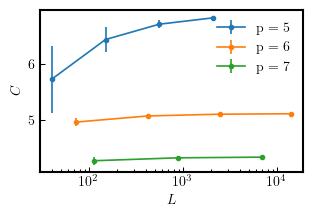

In [30]:
plt.errorbar(lattice54Sizes[3:7],centralChargesp5,yerr = centralChargesVarp5,marker = 'o',markersize = 3,label = 'p = 5')
plt.errorbar(lattice64Sizes[3:7],centralChargesp6,yerr = centralChargesVarp6,marker = 'o',markersize = 3,label = 'p = 6')
plt.errorbar(lattice74Sizes[3:6],centralChargesp7,yerr = centralChargesVarp7,marker = 'o',markersize = 3,label = 'p = 7')
plt.legend()
plt.xlabel(r'$L$')
plt.ylabel(r'$C$')
plt.xscale('log')
print(centralChargesVarp7)
plt.savefig(f'./CentralCharges.eps',format = 'eps', dpi=800, bbox_inches = 'tight',pad_inches = 0.03)

40
150
560


/tmp/ipykernel_148546/803612973.py:12: RuntimeWarning: invalid value encountered in log
  return (c/3)*np.log(1.0/(np.pi*a)*np.sin(np.pi*l))
/tmp/ipykernel_148546/803612973.py:25: RuntimeWarning: overflow encountered in sinh
  return (c/3)*np.log((beta/(np.pi*a)*np.sinh(l*np.pi/beta)))


2090


/tmp/ipykernel_148546/803612973.py:25: RuntimeWarning: overflow encountered in multiply
  return (c/3)*np.log((beta/(np.pi*a)*np.sinh(l*np.pi/beta)))
/tmp/ipykernel_148546/2524006463.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figTemps.show()


[0.3160788812299914, 0.2916437869347248, 0.2823801831694543, 0.2781766557190194] [0.00776683 0.00111706 0.00030398 0.00028932]


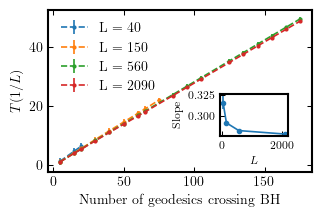

In [4]:
q = 4
tuples = [(5,3),(5,4),(5,5),(5,6)]

figTemps, axTemps = plt.subplots()

centralCharges = []
centralChargesVariance = []
aParameter = []
aParameterVariance = []
slopes = []
slopesVariance = []

for t in tuples:
    p = t[0]
    nLayers = t[1]
    model = md.FractonModel(p,q,nLayers)
    nBorder = len(model.border)
    print(nBorder)
    save_dir = f"../Data/P{p}Q{q}/{nLayers}Layers"
    entropies_dir = os.path.join(save_dir, 'EntropiesBH')
    fname = os.path.join(entropies_dir,"P"+str(p)+"Q"+str(q)+"N"+str(nLayers)+".npy")
    entropies = np.load(fname)
    bHoleRads = sorted(list(set([np.round(g.distanceToOrigin+0.00001,5) for g in model.geodesicList])))
    bHoleRads = [0]+bHoleRads[:17]
    blockSizes = np.linspace(1,nBorder-1,nBorder-1)/nBorder
    parameters,covariance, betas, betas_Var = blackHoleTemperatures(entropies,blockSizes,bHoleRads)
    centralCharges.append(parameters[0])
    centralChargesVariance.append(np.sqrt(covariance[0,0]))
    aParameter.append(parameters[1])
    aParameterVariance.append(np.sqrt(covariance[1,1]))
    geodBH = numGeodesics(model,bHoleRads)
    slope, stderrSlope = cf(lambda x,a: x*a,geodBH,1/betas)
    slopes.append(slope[0])
    slopesVariance.append(np.sqrt(stderrSlope[0,0]))
    axTemps.errorbar(geodBH,1/betas,yerr = 5*np.sqrt(betas_Var[0]),fmt = 'o--',markersize = 2, label = f'L = {nBorder}')
    axTemps.set_xlabel('Number of geodesics crossing BH')
    axTemps.set_ylabel('$T(1/L)$')
left, bottom, width, height = [0.63, 0.28, 0.2, 0.2]
ax2 = figTemps.add_axes([left, bottom, width, height])
ax2.errorbar(lattice54Sizes[3:7],slopes,yerr = np.array(slopesVariance),marker = 'o', markersize = 3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax2.set_ylabel(r'Slope',size = 8)
ax2.set_xlabel(r'$L$',size = 8)
axTemps.legend()
axTemps.tick_params(right= True,top= True,left= True, bottom= True)
figTemps.show()
figTemps.savefig(f'./TemperaturesLinear.eps',format = 'eps', dpi=800, bbox_inches = 'tight',pad_inches = 0.03)
print(slopes, np.array(slopesVariance))

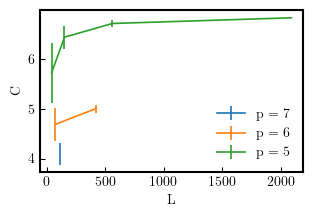

In [39]:
plt.errorbar([112],np.array([centralCharges[0]]),yerr = np.array([centralChargesVariance[0]]),label = 'p = 7')
plt.errorbar([72,420],np.array(centralCharges[1:3]),yerr = np.array(centralChargesVariance[1:3]),label = 'p = 6')
plt.errorbar(lattice54Sizes[3:7],np.array(centralCharges[3:]),yerr = np.array(centralChargesVariance[3:]),label = 'p = 5')
plt.xlabel('L')
plt.ylabel('C')
plt.legend()


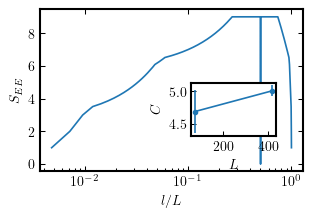

In [26]:
figEntropy, axEntropy = plt.subplots()
left, bottom, width, height = [0.57, 0.28, 0.25, 0.25]
axCentralCharge = figEntropy.add_axes([left, bottom, width, height])
for nLayers in range(4,5):
    blockSizes = np.arange(2,lattice64Sizes[nLayers]+1,1)/lattice64Sizes[nLayers]
    save_dir = f"../Data/P{p}Q{q}/{nLayers}Layers"
    entropies_dir = os.path.join(save_dir, 'EntropiesBH')
    fname = os.path.join(entropies_dir,"P"+str(p)+"Q"+str(q)+"N"+str(nLayers)+".npy")
    entropies = np.load(fname)
    axEntropy.plot(blockSizes,entropies[0,:])
axEntropy.set_xscale('log')
axEntropy.set_ylabel(r'$S_{EE}$')
axEntropy.set_xlabel(r'$l/L$')
axCentralCharge.errorbar(lattice64Sizes[3:5],centralCharges,yerr = np.array(centralChargesVariance), marker = 'o', markersize = 3)
axCentralCharge.set_xlabel(r'$L$')
axCentralCharge.set_ylabel(r'$C$')
axEntropy.tick_params(right= True,top= True,left= True, bottom= True)

#figEntropy.savefig(f'./ZeroTempEntropy.eps',format = 'eps', dpi=800, bbox_inches = 'tight',pad_inches = 0.03)

[0.007766827098881106, 0.0011170559115292443, 0.00030397621092981514, 0.0002893170425587853]
[0.3160788812299914, 0.2916437869347248, 0.2823801831694543, 0.2781766557190194]


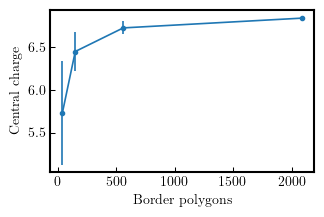

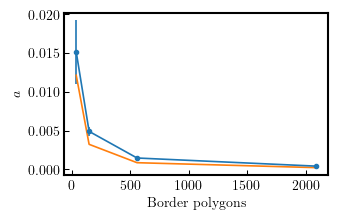

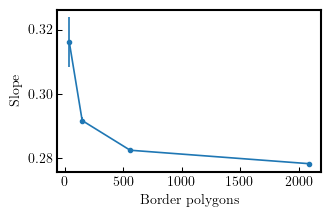

In [8]:
print(slopesVariance)
print(slopes)
plt.errorbar(lattice54Sizes[3:7],centralCharges,yerr = np.array(centralChargesVariance), marker = 'o', markersize = 3)
plt.ylabel('Central charge')
plt.xlabel('Border polygons')
plt.show()

plt.errorbar(lattice54Sizes[3:7],aParameter,yerr = np.array(aParameterVariance),marker = 'o', markersize = 3)
plt.ylabel(r'$a$')
plt.xlabel('Border polygons')
plt.plot(lattice54Sizes[3:7],0.4858682717566456/np.array(lattice54Sizes[3:7]))
plt.show()

plt.errorbar(lattice54Sizes[3:7],slopes,yerr = np.array(slopesVariance), marker = 'o', markersize = 3)
plt.ylabel('Slope')
plt.xlabel('Border polygons')
plt.show()

In [ ]:
plt.errorbar(np.log((1+np.array(bHoleRads[1:]))/((1-np.array(bHoleRads[1:])))),1/np.array(betas), yerr = 3*np.array(beta_Var)/np.power(np.array(betas),2),marker = 'o', markersize = 4)
plt.ylabel(r'$T$')
plt.xlabel(r'Hyperbolic radius')
plt.savefig("./TemperaturesHyperbolicRadii.png", format = 'png', dpi = 800)
plt.show()

par, var = cf(linear,numGeodesics,1/np.array(betas))
print(par,np.sqrt(var))
plt.errorbar(numGeodesics,1/np.array(betas), yerr = 5*np.array(beta_Var),marker = 'o', markersize = 4)
plt.plot(numGeodesics,numGeodesics*par)
plt.ylabel(r'$T$')
plt.xlabel(r'Number of geodesics crossing BH')
plt.show()

plt.errorbar(bHoleRads[1:],np.array(betas), yerr = 3*np.array(beta_Var),marker = 'o', markersize = 4)
plt.ylabel(r'$\beta$')
plt.xlabel(r'Euclidean radius')
plt.show()

## Correlation by countinf geodesics

In [2]:
def correlationByGeodesics(p,q,nLayers):
    '''
    Computes the number of geodesics that span each wedge size for a given p,q hyperbolic lattice
    Inputs:
        p: int, polygon sides
        q: int, coordination number. Only q=4 implemented so far
        
    '''
    save_dir = f"../Data/P{p}Q{q}/{nLayers}Layers"
    correlation_dir = os.path.join(save_dir, 'CorrelationsByGeodesics')
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(correlation_dir, exist_ok=True)
    model = md.FractonModel(p,q,nLayers)
    bHoleRads = sorted(list(set([np.round(g.distanceToOrigin+0.00001,5) for g in model.geodesicList])))
    bHoleRads = [0]+bHoleRads[:20]
    print(f'Done with black holes')
    nBorder = len(model.border)
    correlation = np.zeros((len(bHoleRads),nBorder))
    insidePols = insidePolygons(model)
    print('Done with inside polygons')
    for idx, rad in enumerate(bHoleRads):
        validGeodesics = [idx for idx,g in enumerate(model.geodesicList) if g.distanceToOrigin > rad]
        for g in validGeodesics:
            width = (nBorder-sum(insidePols[g]))/2
            correlation[idx,int(width)] += 1
    fName = f'P{p}Q{q}N{nLayers}.npy'
    np.save(os.path.join(correlation_dir,fName),correlation)
    return correlation


/tmp/ipykernel_51138/1103893029.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figCorr.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


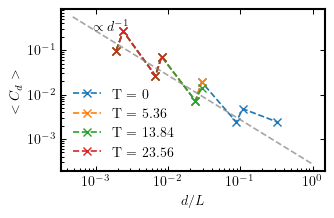

In [9]:
model = md.FractonModel(5,4,5)
bHoleRads = sorted(list(set([np.round(g.distanceToOrigin+0.00001,5) for g in model.geodesicList])))
bHoleRads = [0]+bHoleRads[:20]
p = 5
q = 4
for nLayers in range(6,7):
    save_dir = f"../Data/P{p}Q{q}/{nLayers}Layers"
    correlation_dir = os.path.join(save_dir, 'CorrelationsByGeodesics')
    fName = f'P{p}Q{q}N{nLayers}.npy'
    correlation = np.load(os.path.join(correlation_dir,fName))
    figCorr,axCorr = plt.subplots()
    model = md.FractonModel(p,q,nLayers)
    distances = np.arange(1,len(model.border)+1,1)/(len(model.border))
    for m in range(4):
        nonZeroCorr = correlation[3*m,:]>0
        if m== 0:
            T = 0
        else: 
            T = round(1/betas[3*m-1],2)
        axCorr.plot(distances[nonZeroCorr],correlation[2*m,nonZeroCorr],'x--', label = f'T = {T}')
    axCorr.legend()
axCorr.plot(distances, 0.00027*np.power(distances,-1), '--',color = 'gray',alpha = 0.7)
axCorr.set_xscale('log')
axCorr.set_yscale('log')
axCorr.set_ylabel(r'$<C_d>$')
axCorr.set_xlabel(r'$d/L$')
axCorr.text(0.0009,0.28,r'$\propto d^{-1}$')
axCorr.tick_params(right= True,top= True,left= True, bottom= True)

figCorr.show()
figCorr.savefig(f'./Correlations.eps',format = 'eps', dpi=800, bbox_inches = 'tight',pad_inches = 0.03)


## Useful plots and figures

In [138]:
def geodesic(z1,z2,color,style,circle=False):
    if (np.round(np.real(z1)*np.imag(z2)-np.real(z2)*np.imag(z1),2))!= 0:
        a = (np.imag(z1)*(np.abs(z2)**2+1)-np.imag(z2)*(np.abs(z1)**2+1))/(np.real(z1)*np.imag(z2)-np.real(z2)*np.imag(z1))
        b = (np.real(z2)*(np.abs(z1)**2+1)-np.real(z1)*(np.abs(z2)**2+1))/(np.real(z1)*np.imag(z2)-np.real(z2)*np.imag(z1))
        r = np.sqrt((a**2+b**2)/4-1)
        if -np.pi/2<np.angle(z1) and np.angle(z1)<np.pi/2:
            theta0 = np.angle(z1+a/2+1j*b/2)
            theta1 = np.angle(z2+a/2+1j*b/2)
            if theta0 < 0:
                theta0 += 2*np.pi
            if theta1 < 0:
                theta1 += 2*np.pi
        else:
            theta0 = np.angle(z1+a/2+1j*b/2)
            theta1 = np.angle(z2+a/2+1j*b/2)
        theta = np.linspace(theta0,theta1,30)
        if circle:
            theta = np.linspace(0,2*np.pi,100)
        ax = plt.gca()
        zs = r*np.cos(theta)-a/2+1j*(r*np.sin(theta)-b/2)
        ax.plot(np.real(zs),np.imag(zs),style,color=color)
    else:
        ax = plt.gca()
        ax.plot([z1.real,z2.real],[z1.imag,z2.imag],style,color = color)


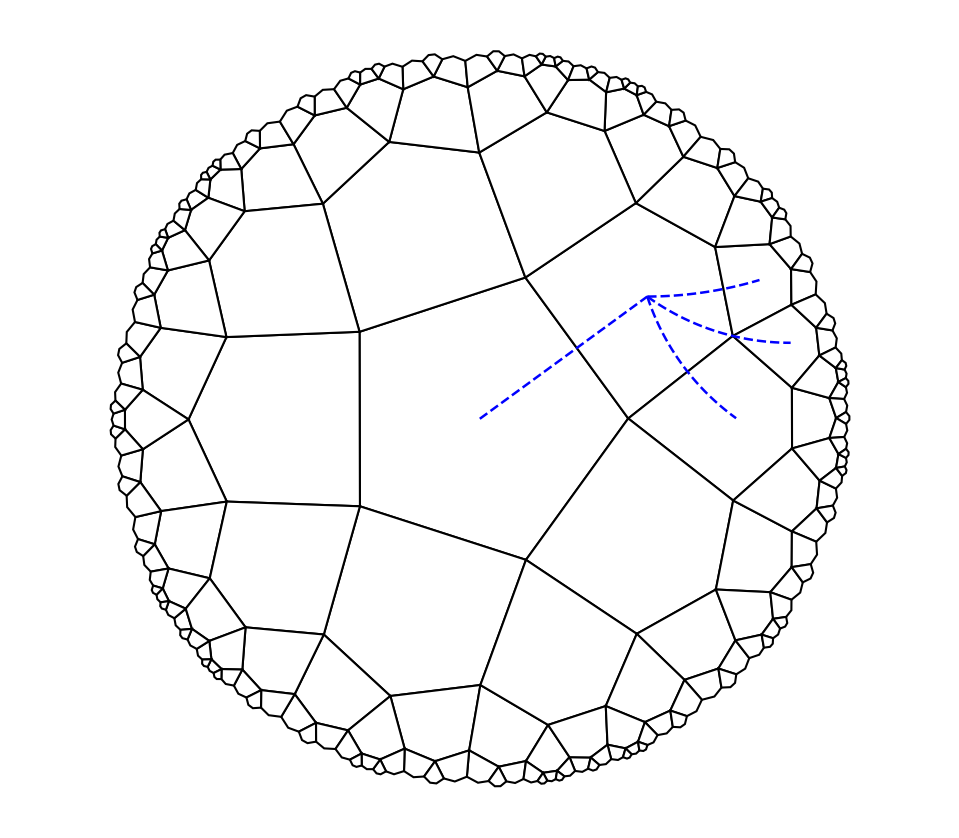

In [141]:

model = md.FractonModel(5,4,4)
fig, ax = model.quick_plot()
for c in model.centers:
    pass
    #ax.scatter(c.real,c.imag,color = 'r')
geodesic(model.centers[0],model.centers[1],'b','--')
geodesic(model.centers[1],model.centers[2],'b','--')
geodesic(model.centers[1],model.centers[3],'b','--')
geodesic(model.centers[1],model.centers[4],'b','--')
